# Unconfined Aquifer
Jupyter Notebook adapted from FloPy Tutorial 2: http://modflowpy.github.io/flopydoc/tutorial2.html

FloPy Code Description (parameter functions, defaults, and data types): http://modflowpy.github.io/flopydoc/code.html

MODFLOW-2005 Guide (generally more informative parameter descriptions): https://water.usgs.gov/ogw/modflow/MODFLOW-2005-Guide/

Matplotlib Gallery/Examples (full details (including jupyter notebooks!) of plotting code): https://matplotlib.org/gallery/index.html

NumPy Reference Manual (full details of NumPy code): https://docs.scipy.org/doc/numpy-1.13.0/reference/index.html

Package output files saved in the directory with appropriate extensions; this parameter can be changed.

All object files are then fed into the modelling programme to determine groundwater flow.

### Jupyter Notebook Shortcuts

Command Mode (blue, 'ESC')

     H = help (shortcut list)         C = copy cell             Y = code                     arrow = scroll through cells
     A = insert cell above            X = cut cell              M = markup             shift-arrow = highlight  cells
     B = insert cell below            V = paste below         6-1 = heading size           shift-M = merge cells
    DD = delete cell            shift-V = paste above               number of #s
         
Edit Mode (green, 'Enter')

     ctrl-enter = run cell                          ctrl-Z = undo                       tab or ctrl-[ = indent (line start)
    shift-enter = & select below              ctrl-shift-Z = redo                              ctrl-] = dedent (line start)
      alt-enter = & insert below       control-shift-minus = split cell (above current line)

...

## Import Modules

In [59]:
import numpy as np  #'numpy' = 'fundamental package for scientific computing with python'
import flopy        #'flopy' = 'package for creating, running, and post-processing MODLFOW-based models with python'
                    #'import__as__' = searches for the named module and binds the result to a name/alias in local scope

## Create Model Object
Modpath (mp) base class information: https://modflowpy.github.io/flopydoc/mp.html

In [60]:
modelname = 'unconfined'  #assign modflow model object name
mf = flopy.modflow.Modflow(modelname, exe_name='mf2005') #create modflow model object and specify executable
            # object = python module.flopy module.module class(class parameters)
print(mf)   #'print' = details of given object - useful for assessing what's going on

MODFLOW 0 layer(s), 0 row(s), 0 column(s), 0 stress period(s)


...

## Discretisation (DIS) Package
mfdis class information: http://modflowpy.github.io/flopydoc/mfdis.html

### Define Model Domain

In [61]:
Lx = 1000.       #'Lx' = grid length in x-direction                                                                
Ly = 1000.       #'Ly' = grid length in y-direction                                                                   
ztop = 0.        #'ztop' = highest elevation in z-direction                                                                
zbot = -50.      #'zbot' = lowest elevation in z-direction                                                                

### Define MODFLOW Grid

In [62]:
nlay = 1         #'nlay' = number of layers
nrow = 10        #'nrow' = number of rows                                                              
ncol = 10        #'ncol' = number of columns                                                              
delr = Lx/ncol         #'delr' = array of spacings along row                                                                
delc = Ly/nrow         #'delr' = array of spacings along column                                                             
delv = (ztop - zbot) / nlay      #'delr' = array of spacings along column                                                  
botm = np.linspace(ztop, zbot, nlay + 1)      #'botm' = array of bottom elevation for each cell

### DefineTime Parameters

In [63]:
nper = 3                         #'nper' = number of model stress periods
perlen = [1, 100, 100]           #'perlen' = array of the stress period lengths
nstp = [1, 100, 100]             #'nstp' = number of time steps in each stress period
steady = [True, False, False]    #'steady' = stress field steady state indication - true or false

### Create DIS Object

In [64]:
dis = flopy.modflow.ModflowDis(mf, nlay=nlay, nrow=nrow, ncol=ncol, delr=delr, delc=delc, top=ztop, botm=botm[1:],
                               nper=nper, perlen=perlen, nstp=nstp, steady=steady,) # all parameters as above

...

## Basic (BAS) Package 
mfbas class information: http://modflowpy.github.io/flopydoc/mfbas.html

### Define Basic Parameters

In [65]:
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)         #'ibound' = boundary conditions - equal conditions in all cells
        #'ibound[:, :, 0] = -1' = no flow (-1) though all (:) layers and rows in first columnn (0)
        #'ibound[:, :, -1] = -1' = no flow (-1) though all (:) layers and rows in last columnn (-1)
strt = 10*np.ones((nlay, nrow, ncol), dtype=np.float32)      #'strt' = starting head - 10 within all cells
        #'strt[:, :, 0] = 9.' = starting head of 9 in all (:) layers and rows in first columnn (0)
        #'strt[:, :, -1] = 0.' = starting head of 0 in all (:) layers and rows in first columnn (0)

### Create BAS Object

In [66]:
bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt) # (model,boundary conditions,starting heads)

...

## Layer Property Flow (LPF) Package 
mflpf class information: http://modflowpy.github.io/flopydoc/mflpf.html

### Define Layer Flow Parameters

In [67]:
hk = 1.      #'hk' = horizontal hydraulic conductivity along rows
vka = 1.     #'vka' = vertical hydraulic conductivity along rows
sy = 0.15    #'sy' = specific yield
ss = 10.e-5  #'ss' = specific storage
laytyp = 1   #'laytip' = layer type - (1 = unconfined, 0 = confined)

### Create LPF Object

In [68]:
lpf = flopy.modflow.ModflowLpf(mf, laytyp=laytyp, hk=hk, vka=vka, ss=ss, sy=sy,ipakcb=53)

...

## General-Head Boundary (GHB) Package
mfghb class information: https://modflowpy.github.io/flopydoc/mfghb.html

### Define Stress Period 1

In [69]:
stagel = 10.           #'stageleft' = left boundary head
stager = 10.           #'stageright' = right boundary head
bound_sp1 = []         #'bound_sp1' = name array of stress period parameters
for il in range(nlay):                   # for 0 in range(0, 1) - no effect with 1 layer
    condl = hk * (stagel - zbot) * delc  #'condleft' = left boundary conductance
    condr = hk * (stager - zbot) * delc  #'condright' = right boundary conductance
    for ir in range(nrow):                                     # for 9 in range(0, 10)
        bound_sp1.append([il, ir, 0, stagel, condl])           # define first GHB cel
        bound_sp1.append([il, ir, ncol - 1, stager, condr])    # define last GHB cell
print ('Adding', len(bound_sp1), 'GHBs for stress period 1.')  # print number of GHB cells

Adding 20 GHBs for stress period 1.


### Define Stress Period 2

In [70]:
stagel = 10.           #'stageleft' = left boundary head
stager = 0.            #'stageright' = right boundary head
bound_sp2 = []         #'bound_sp1' = name array of stress period parameters
for il in range(nlay):                   # for 0 in range(0, 1) - no effect with 1 layer
    condl = hk * (stagel - zbot) * delc  #'condleft' = left boundary conductance
    condr = hk * (stager - zbot) * delc  #'condright' = left boundary conductance
    for ir in range(nrow):                                     # for 9 in range(0, 10)
        bound_sp2.append([il, ir, 0, stagel, condl])           # define first GHB cell
        bound_sp2.append([il, ir, ncol - 1, stager, condr])    # define last GHB cell
print ('Adding', len(bound_sp2), 'GHBs for stress period 2.')  # print number of GHB cells

Adding 20 GHBs for stress period 2.


### Create SP Dictionary

In [71]:
spd = {0: bound_sp1, 1: bound_sp2}  #'stress_period_data' = list of boundaries for stress periods
                                    # stress periods themselves defined by a list of boundaries
                                    # last defined stress period applies to any undefined periods that follow

### Create GHB Object

In [72]:
ghb = flopy.modflow.ModflowGhb(mf, stress_period_data=spd)

...

## Well (WEL) Package
mfwel class infromation: https://modflowpy.github.io/flopydoc/mfwel.html

### Define Well Parameters

In [73]:
# Define well position and abstraction during each stress period - [lay, row, col, flux]
pumping_rate = -100     #'pumping_rate' = define rate of abstraction - must be negative
wel_sp1 = [[0, nrow/2 - 1, ncol/2 - 1, 0.]]            #'0' = no abstraction
wel_sp2 = [[0, nrow/2 - 1, ncol/2 - 1, 0.]]            #'0' = no abstraction
wel_sp3 = [[0, nrow/2 - 1, ncol/2 - 1, pumping_rate]]  #'<0' = abstraction
    #position [0, nrow/2 -1, ncol/2 -1] is obviously the same throughout

### Create SP Dictionary

In [74]:
spd = {0: wel_sp1, 1: wel_sp2, 2: wel_sp3}

### Create WEL Object

In [75]:
wel = flopy.modflow.ModflowWel(mf, stress_period_data=spd)

...

## Output Control (OC) Package
mfoc class information: http://modflowpy.github.io/flopydoc/mfoc.html

### Create SP Dictionary

In [76]:
spd = {(0, 0): ['print head', 'print budget', 'save head', 'save budget']}
    #'(IPEROC, ITSOC)' = first stress period (PER) and time step (TS), in stress period, at which output is desired - 0 = 1st
    #'print' = model output written to the internal list file
    #'save' = model output written to an external binary file
    #'print head' = 
    #'save head' = 
    #'print budget' = write overall volumetric budget to a list file
    #'save budget' = write cell-by-cell budget data to a binary file

### Create OC Object

In [77]:
oc = flopy.modflow.ModflowOc(mf, stress_period_data=spd, compact=True)
    #'compact' = saves time step size, stress period elapsed time, and total elapsed time within budget file to reduce size

...

## Preconditioned Conjugate Gradient (PCG) Package
mfpcg class information: http://modflowpy.github.io/flopydoc/mfpcg.html

In [78]:
pcg = flopy.modflow.ModflowPcg(mf) #'mf' = model; all other parameters set to defaults
    #mxiter=50, iter1=30, npcond=1, hclose=1e-05, rclose=1e-05, relax=1.0
    #nbpol=0, iprpcg=0, mutpcg=3, damp=1.0, dampt=1.0, ihcofadd=0

...

## Write MODFLOW Data Files
Modpath (mp) base class information: https://modflowpy.github.io/flopydoc/mp.html

In [79]:
mf.write_input() # writes all output files as controlled by previously created package objects

...

## Run MODFLOW Model
Modpath (mp) base class information: https://modflowpy.github.io/flopydoc/mp.html

Flopy can run the model object (mf) through the model programme (mf2005).

Model object and programme are specified at the beginning of the notebook.

The programme must be located within the system path or working directory.

In [80]:
success, mfoutput = mf.run_model(silent=True, pause=False, report=True)  # model is run if successful
if not success:                                                          # if the model is not run
    raise Exception('MODFLOW did not terminate normally.')               # print an error message

...

## Post-Processing Results
matplotlib code: https://matplotlib.org/gallery/index.html

### Import Libraries

In [81]:
%matplotlib inline
        #'%' = line-oriented magic function = all subsequent words on line are arguments for the first (including after #)
        #'%%' = cell-oriented magic function = all subsequent words in cell are arguments for the first
        #'matplotlib' = library for plotting 2D figures with python
        #'inline' = changes backend matlibplot to produce plots below requested cell at frontend (Jupyter)

### Matplotlib Settings

In [82]:
import matplotlib.pyplot as plt       # plotting                              
import flopy.utils.binaryfile as bf   # binary file reading                                

### Matplotlib Settings

In [83]:
%matplotlib inline
        #'%' = line-oriented magic function = all subsequent words on line are arguments for the first (including after #)
        #'%%' = cell-oriented magic function = all subsequent words in cell are arguments for the first
        #'matplotlib' = library for plotting 2D figures with python
        #'inline' = changes backend matlibplot to produce plots below requested cell at frontend (Jupyter)

### Create Headfile Object

In [84]:
HeadObj = bf.HeadFile(modelname+'.hds')  #                                            
times = HeadObj.get_times()              #                                           

### Define Contour Parameters

In [85]:
levels = np.linspace(0, 10, 11)                          #'linespace' = contour spacing - (lowest, highest, number)
extent = (delr/2., Lx - delr/2., delc/2., Ly - delc/2.)  #'extent' = axes limits - (left, right, bottom, top)
print ('Levels: ', levels)                               # print array of contour values
print ('Extent: ', extent)                               # print array of axes limit values

Levels:  [  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.]
Extent:  (50.0, 950.0, 50.0, 950.0)


### Create Well Point

In [86]:
wpt = ((float(ncol/2)-0.5)*delr, (float(nrow/2-1)+0.5)*delc)
wpt = (450., 550.)                                              # well position

### Create Plots
Subsections must appear in the same cell to run through the same for loop and appear in the correct order



    Processing Time:  1.0
    Head Stats: Min:  10.0
                Max:  10.0
                STD:  0.0


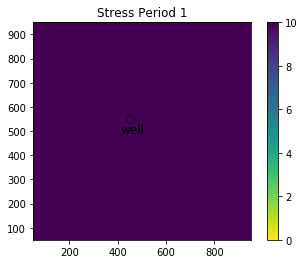



    Processing Time:  101.0
    Head Stats: Min:  0.0110888
                Max:  9.99076
                STD:  3.18494


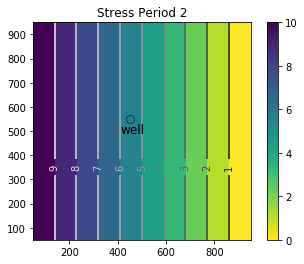



    Processing Time:  201.0
    Head Stats: Min:  0.00998603
                Max:  9.99018
                STD:  3.17831


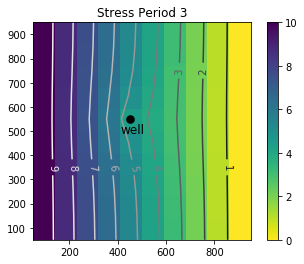

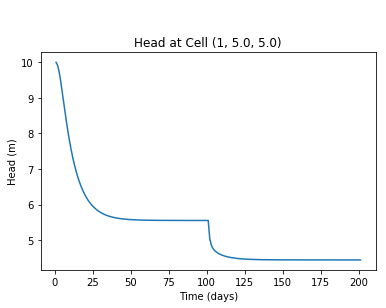

(0, 4.0, 4.0)


In [88]:
mytimes = [1.0, 101.0, 201.0]                # array of times at which to plot output
for iplot, time in enumerate(mytimes):       #'enumerate' = count variable position within array
    
    #'subplot' = create subplot
    #plt.subplot(1, len(mytimes), iplot + 1, aspect='equal')
    plt.subplot(1, 1, 1, aspect='equal')
            # subplot(A,B,C,D): A = rows, B = columns, C = section, D = equal axes ratio
        
    print ('\n\n    Processing Time: ', time)    # print time after start represented by output
    head = HeadObj.get_data(totim=time)          #
    
    # Calculate/Print statistics
    print ('    Head Stats: Min: ', head.min())  # calculate and print minimum head
    print ('                Max: ', head.max())  # calculate and print maximum head          
    print ('                STD: ', head.std())  # calculate and print standard deviation in head

    #'title' = plot title
    plt.title('Stress Period ' + str(iplot + 1))                                    
            #'title('A' B(n))' = print text (A) and nth value of array (B)
        
    #'imshow' = plot image (surface) on axes
    plt.imshow(head[0, :, :], extent=extent, cmap='viridis_r', vmin=0., vmax=10.)
            #'head[0,;,;]' = matrix of values for head of layer 1 in all rows and columns, 'extent' = axes limits
            #'cmap' = colorbar name, 'vmin' = minimum colorbar value, 'vmax' = maximum colorbar value
            
    plt.colorbar()          #'colourbar' = plot most recently used colorbar
            
    #'contour' = plot contours
    CS = plt.contour(np.flipud(head[0, :, :]), cmap='Greys_r', levels=levels, extent=extent, order=10)
            #'flipud' = flip array up/down, head[0,;,;]' = matrix of values for head of layer 1 in all rows and columns,
            #'cmap' = colorbar name,'levels' = contour values, extent' = axes limits,
            
    #'clabel' = plot contour labels       
    plt.clabel(CS, inline=1, fontsize=10, fmt='%1.0f', zorder=12) 
            #'CS' = name of contour object, 'inline' =, 'fmt' = data format, 'zorder' = drawing order
    
    # Define well point colour
    mfc = 'None'                   #'mfc' = marker face colour
    if (iplot+1) == len(mytimes):  # when abstracting                  
        mfc='black'                # change mfc to black
        
    #'plot' = plot well point    
    plt.plot(wpt[0], wpt[1], lw=0, marker='o', ms=8, mew=0.5, mec='black', mfc=mfc, zorder=9)  # plot well point
            #'wpt[0]' = x-axis position, 'wpt[1]' = y-axis position  <- both same as well point position
            #'lw' = line width, 'marker' = marker shape, 'ms' = marker size, 'mew' = marker edge width,
            #'mec' = marker edge colour, 'mfc' = marker face colour, 'zorder' = drawing order (low z = low layer = first)
    
    #'text' = plot text on plot
    plt.text(wpt[0]-40, wpt[1]-60, 'well', size=12, zorder=12)
            #(A,B,C,D,E): A = x-axis position, B = y-axis position  <- both relative to well point position
            # C = text printed, D = text size, E = drawing order
            
    plt.show()  #'show' = display plot (plots overlap if not indented)
plt.show()      # not actually required

# Plot head vs time
idx = (0, nrow/2 - 1, ncol/2 - 1)  #
ts = HeadObj.get_ts(idx)           #
plt.title('\n\nHead at Cell ({0}, {1}, {2})'.format(idx[0] + 1, idx[1] + 1, idx[2] + 1))
plt.xlabel('Time (days)')          #'xlabel' = plot x label
plt.ylabel('Head (m)')             #'ylabel' = plot y label
plt.plot(ts[:, 0], ts[:, 1])       #'plot(x,y)' = plot ts column 1 (time) against ts column 2 (head)
plt.show()                         #'show' = display plot
print(idx)


...

## Plot Summary

### Varying Specific Yield/Storage

SS has an effect on the response of water - gradient of curve towards euilibrium. More important in confined aquifers.
SY has a similar effect but i didnt really hear. More important in unconfined aquifers. More effect at low K.
Neither SS or SY change the steady state head; just rate at which it is reached.

### Varying Hydraulic Conductivity

#### Changes in Output

K > 10^-3 = very little change

K = 10^-4 = significant change

K < 10^-5 = ~complete drainage

#### Head Values

10^-0 K: mean(101) = 5.000, mean(201) = 4.800, std(101) = 3.185, std(201) = 3.178

10^-1 K: mean(101) = 5.000, mean(201) = 4.800, std(101) = 3.185, std(201) = 3.178

10^-2 K: mean(101) = 5.001, mean(201) = 4.800, std(101) = 3.128, std(201) = 3.121

10^-3 K: mean(101) = 5.077, mean(201) = 4.787, std(101) = 2.651, std(201) = 2.645

10^-4 K: mean(101) = 5.305, mean(201) = 4.196, std(101) = 1.051, std(201) = 1.051

10^-5 K: mean(101) = 5.967, mean(201) = 0.097, std(101) = 0.148, std(201) = 0.172

10^-6 K: mean(101) = 9.104, mean(201) = 0.000, std(101) = 0.015, std(201) = 0.089

#### Interpretation of Values

Reduced K = reduced head gradient = reduced flow rate = increased equilibration time.

Reduced K = higher head at natural (sp2) equilibrium & lower head at pumping (sp3) equilibrium.